<a href="https://colab.research.google.com/github/Omorusi/Neural-network/blob/main/Apple_%26_Tomatoes_classifier_CNN_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Libraries

In [23]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import glob
import torchvision
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision import datasets  # Ensure this line is present


In [24]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("samuelcortinhas/apples-or-tomatoes-image-classification")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/samuelcortinhas/apples-or-tomatoes-image-classification/versions/1


#Data Preparation

In [25]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import glob
 #folder/train/tomatoes/
  #folder/train/apples/
# Assuming 'path' is the folder where the dataset is downloaded
train_folder_apples = os.path.join(path, 'train/apples')  # Folder containing training images
test_folder_apples = os.path.join(path, 'test/apples')    # Folder containing testing images

train_folder_tomatoes = os.path.join(path, 'train/tomatoes')  # Folder containing training images
test_folder_tomatoes = os.path.join(path, 'test/tomatoes')    # Folder containing testing images


# Define dataset paths
train_folder = os.path.join(path, 'train')
test_folder = os.path.join(path, 'test')



# Get all image file paths from train/apples and test/apples folders
train_image_files_apples = glob.glob(os.path.join(train_folder, 'apples', '*.*'))
test_image_files_apples = glob.glob(os.path.join(test_folder, 'apples', '*.*'))




Displaying train images:


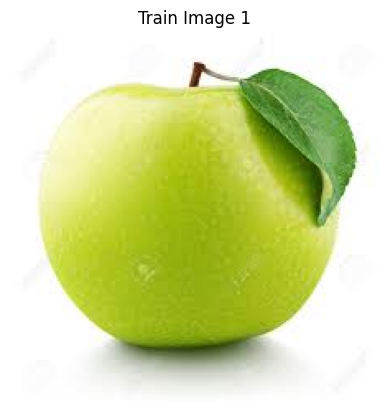

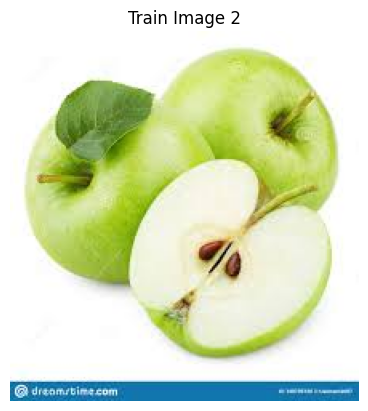

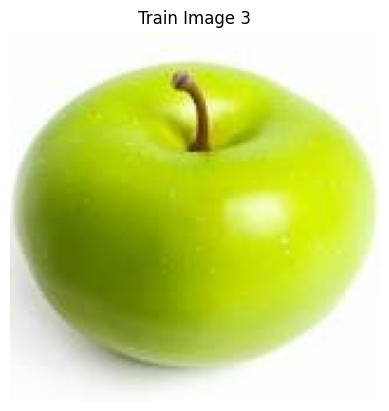

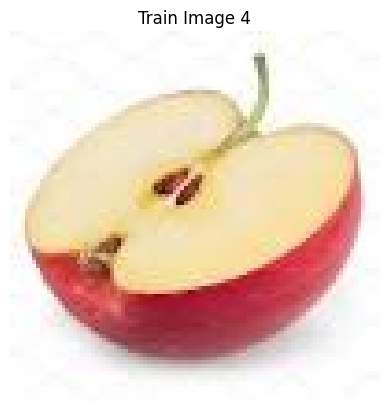

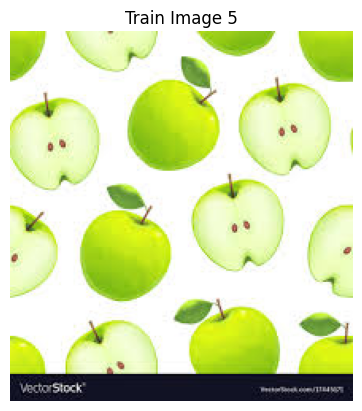

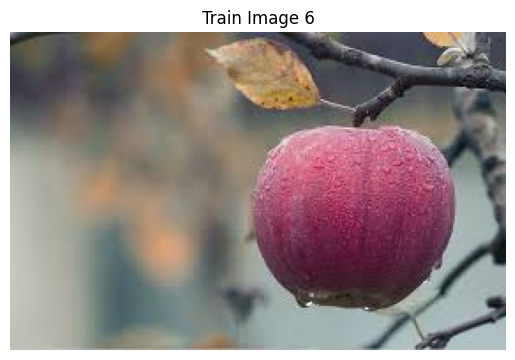

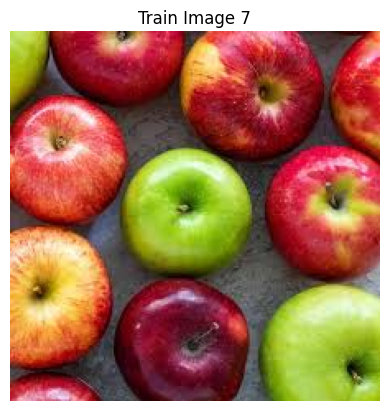

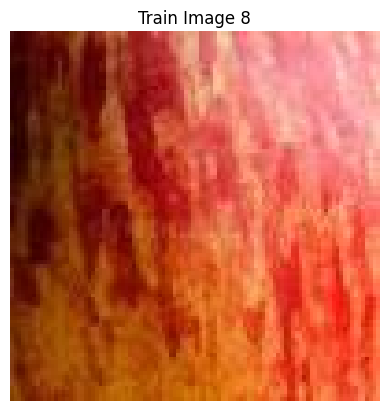

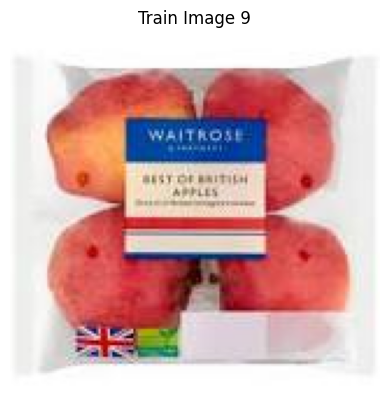

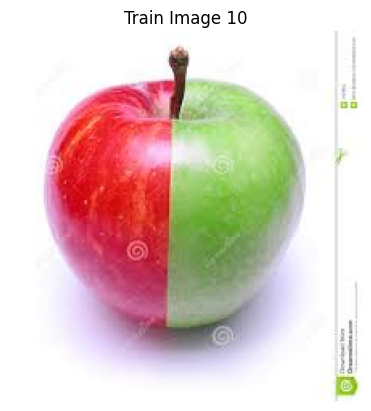

Displaying test images:


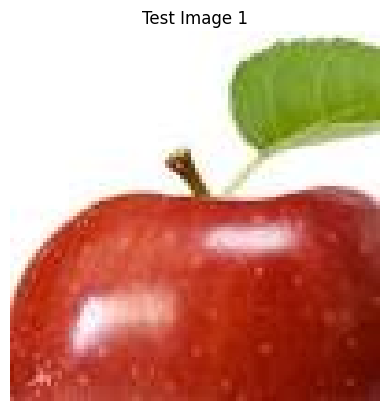

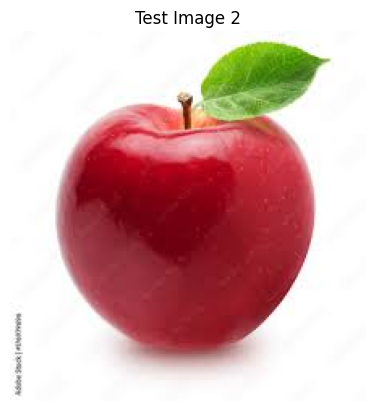

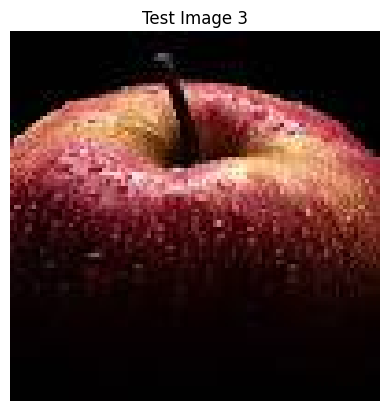

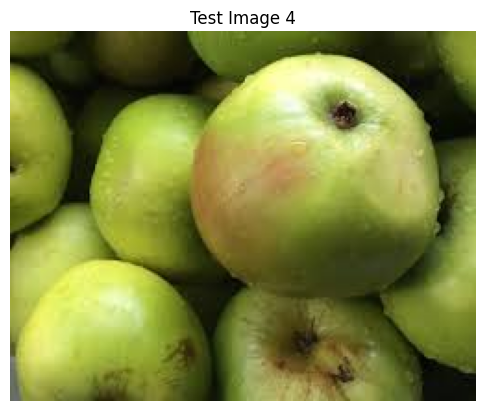

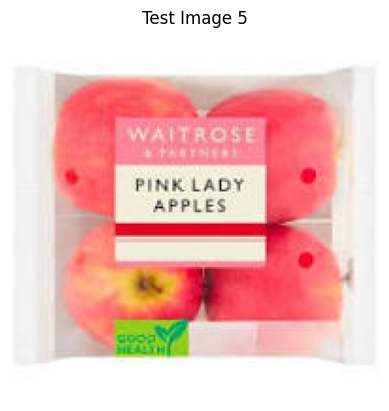

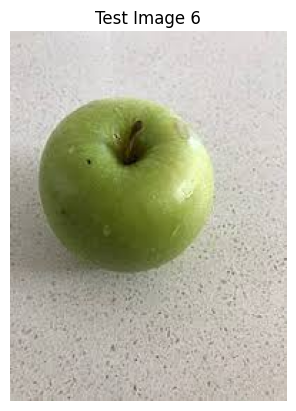

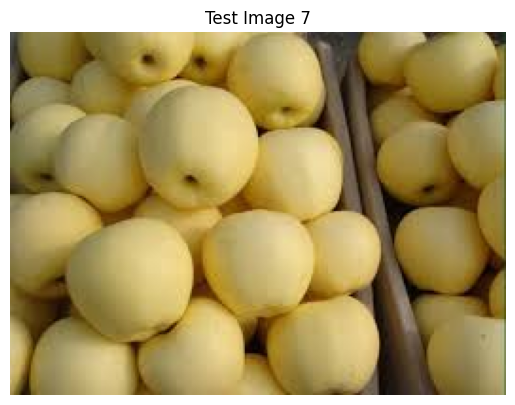

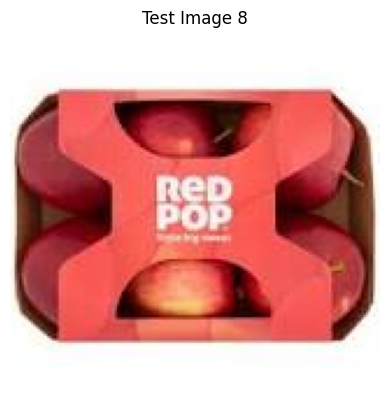

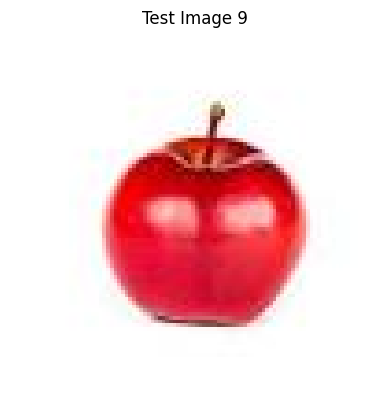

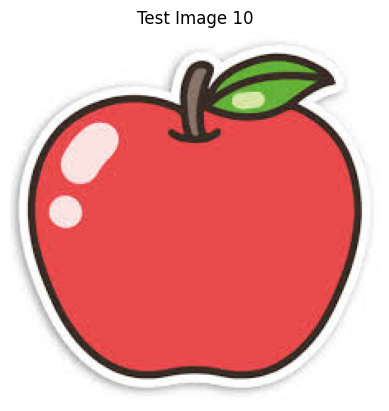

In [26]:

# Display the first few images from the 'train' folder
print("Displaying train images:")
num_train_images_to_display = min(10, len(train_image_files_apples))  # Show up to 10 or the available images
for i in range(num_train_images_to_display):
    img = Image.open(train_image_files_apples[i])
    plt.figure()
    plt.imshow(img)
    plt.title(f"Train Image {i+1}")
    plt.axis('off')
    plt.show()

# Display the first few images from the 'test' folder
print("Displaying test images:")
num_test_images_to_display = min(10, len(test_image_files_apples))  # Show up to 10 or the available images
for i in range(num_test_images_to_display):
    img = Image.open(test_image_files_apples[i])
    plt.figure()
    plt.imshow(img)
    plt.title(f"Test Image {i+1}")
    plt.axis('off')
    plt.show()


Displaying train images:


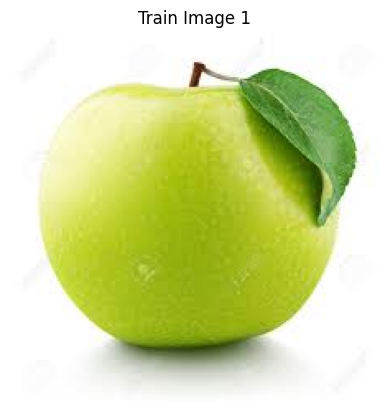

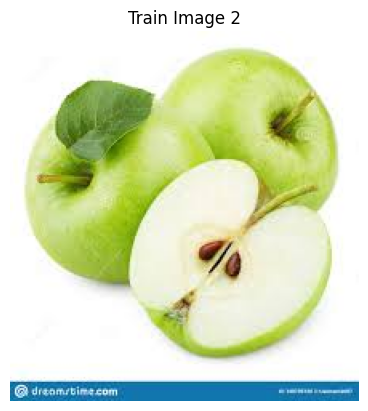

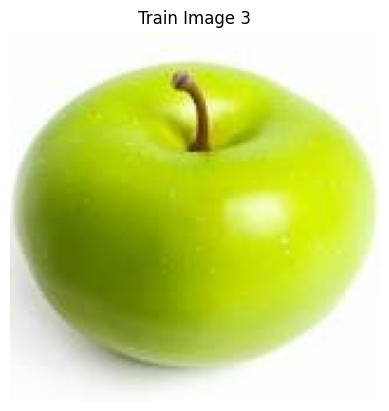

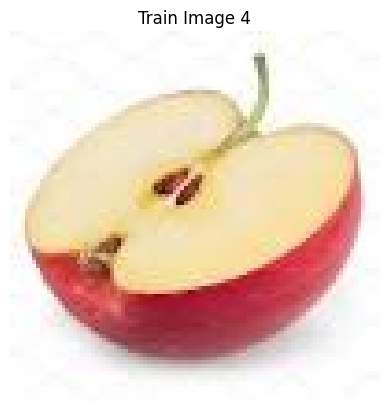

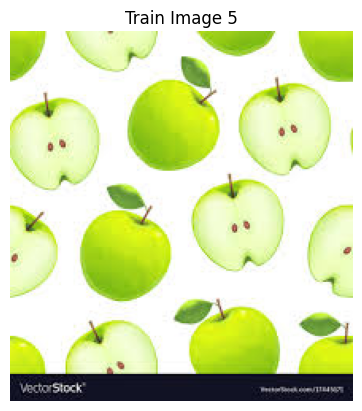

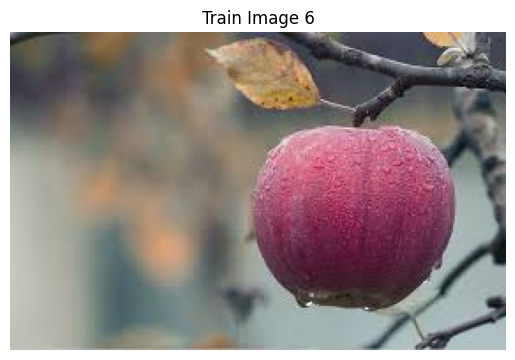

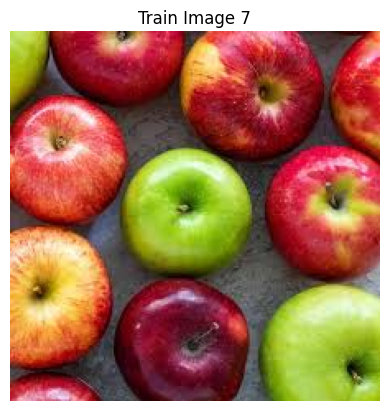

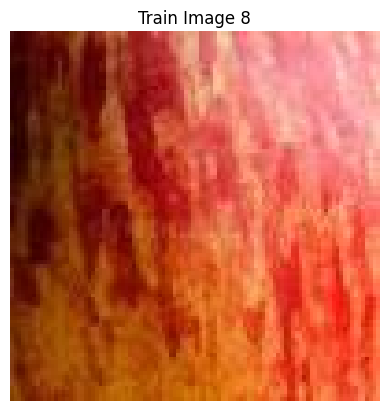

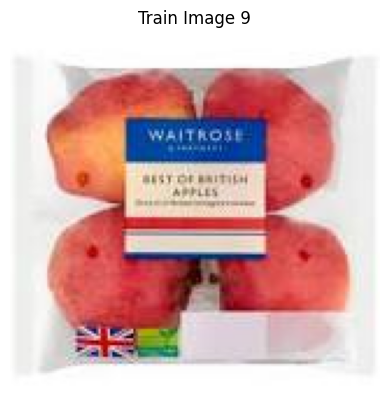

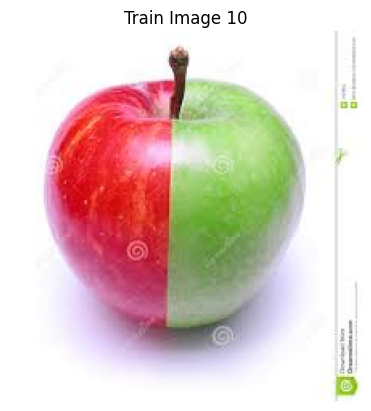

Displaying test images:


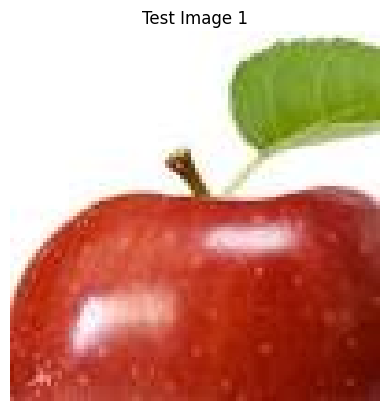

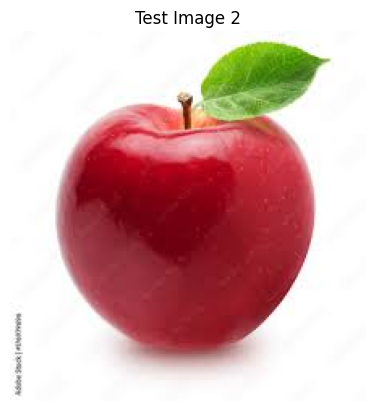

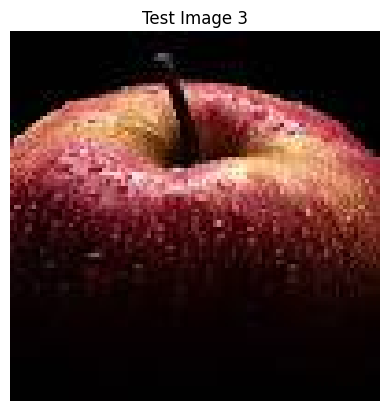

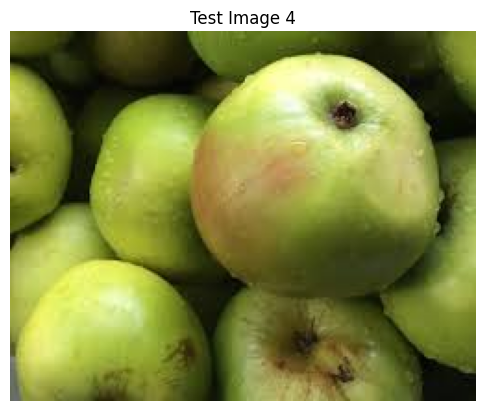

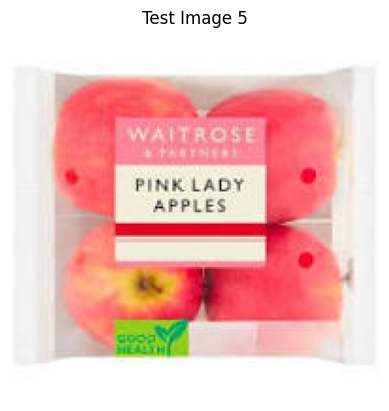

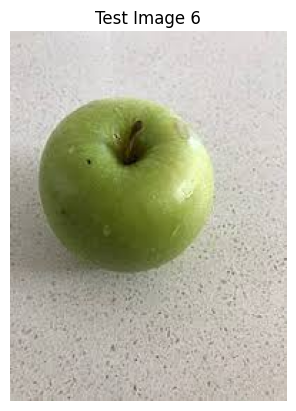

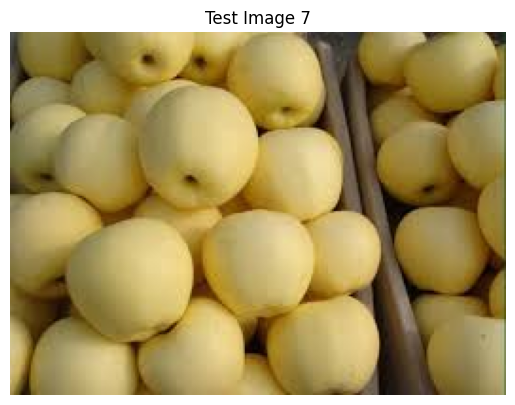

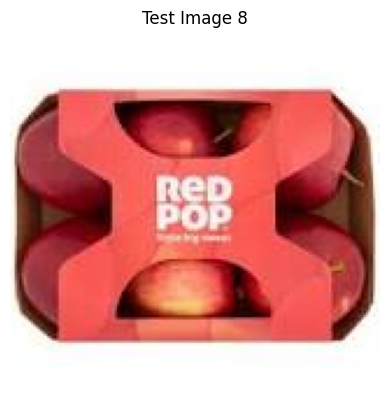

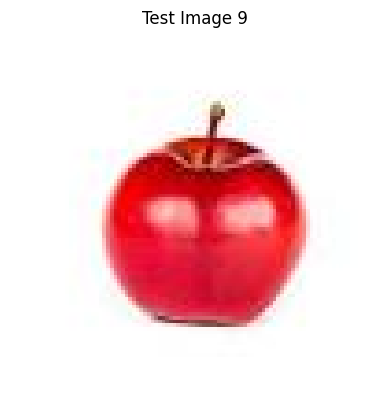

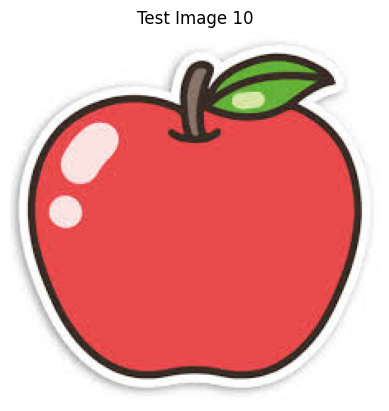

In [27]:
import glob


# Display the first few images from the 'train' folder
print("Displaying train images:")
num_train_images_to_display = min(10, len(train_image_files_apples))  # Show up to 10 or the available images
for i in range(num_train_images_to_display):
    img = Image.open(train_image_files_apples[i])
    plt.figure()
    plt.imshow(img)
    plt.title(f"Train Image {i+1}")
    plt.axis('off')
    plt.show()

# Display the first few images from the 'test' folder
print("Displaying test images:")
num_test_images_to_display = min(10, len(test_image_files_apples))  # Show up to 10 or the available images
for i in range(num_test_images_to_display):
    img = Image.open(test_image_files_apples[i])
    plt.figure()
    plt.imshow(img)
    plt.title(f"Test Image {i+1}")
    plt.axis('off')
    plt.show()


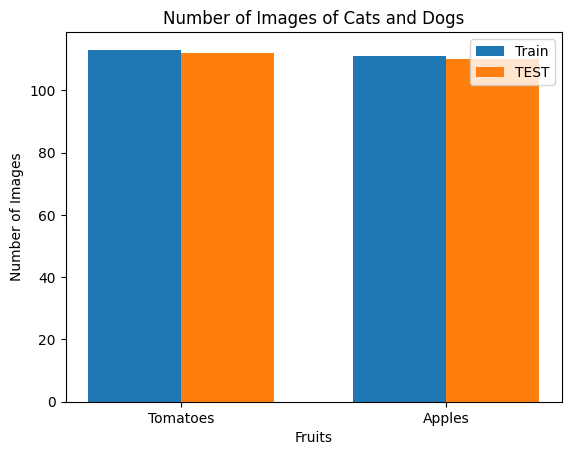

In [28]:
import numpy as np
import matplotlib.pyplot as plt

# Define the counts for cats and dogs in validation and train sets
tomatoes_test_count = len(test_folder_tomatoes)
apples_test_count = len(test_folder_apples)
tomatoes_train_count = len(train_folder_tomatoes)
apples_train_count = len(train_folder_apples)

# Create the labels for the x-axis
labels = ['Tomatoes', 'Apples']

# Create the counts for validation and train sets
validation_counts = [tomatoes_test_count, apples_test_count]
train_counts = [tomatoes_train_count, apples_train_count]

# Set the positions and width of the bars
positions = np.arange(len(labels))
bar_width = 0.35

# Plot the bars
plt.bar(positions - bar_width/2, train_counts, bar_width, label='Train')
plt.bar(positions + bar_width/2, validation_counts, bar_width, label='TEST')

# Set the labels and title
plt.xlabel('Fruits')
plt.ylabel('Number of Images')
plt.title('Number of Images of Cats and Dogs')

# Set the x-axis tick labels
plt.xticks(positions, labels)

# Add a legend
plt.legend()

# Show the plot
plt.show()

In [29]:
# -------------------------------
# STEP 2: Define Image Transformations
# -------------------------------
def convert_channels(image):
    image = np.array(image)
    if image.shape[2] == 4:  # RGBA -> RGB
        image = image[:, :, :3]
    elif image.shape[2] == 1:  # Grayscale -> RGB
        image = np.concatenate([image]*3, axis=2)
    return Image.fromarray(image)

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.Lambda(convert_channels),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5341, 0.5063, 0.4630],
                         std=[0.2098, 0.2081, 0.2181])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Lambda(convert_channels),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5341, 0.5063, 0.4630],
                         std=[0.2098, 0.2081, 0.2181])
])



#Load Dataset

In [30]:

dataset = datasets.ImageFolder(root=train_folder, transform=train_transforms)
train_size = int(0.8 * len(dataset))
valid_size = len(dataset) - train_size
train_dataset, valid_dataset = torch.utils.data.random_split(dataset, [train_size, valid_size])
valid_dataset.dataset.transform = val_transforms

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=1, shuffle=False)

test_dataset = datasets.ImageFolder(root=test_folder, transform=val_transforms)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)




#Define CNN Model

In [31]:
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv5 = nn.Conv2d(256, 512, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(512 * 7 * 7, 512)
        self.fc2 = nn.Linear(512, 2)  # Two classes: apples and tomatoes

    def forward(self, x):
        x = self.pool(F.leaky_relu(self.conv1(x), negative_slope=0.01))
        x = self.pool(F.leaky_relu(self.conv2(x), negative_slope=0.01))
        x = self.pool(F.leaky_relu(self.conv3(x), negative_slope=0.01))
        x = self.pool(F.leaky_relu(self.conv4(x), negative_slope=0.01))
        x = self.pool(F.leaky_relu(self.conv5(x), negative_slope=0.01))
        x = x.view(-1, 512 * 7 * 7)
        x = F.leaky_relu(self.fc1(x), negative_slope=0.01)
        x = self.fc2(x)
        return x




#Train and Evaluate Model

In [32]:


def train_model(model, train_loader, valid_loader, device, epochs=5):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}")

def evaluate_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f'Model Accuracy: {accuracy:.2f}%')
    return accuracy

#Initialize Model and Device and train model

In [33]:

if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)

    # Initialize model
    model = SimpleCNN().to(device)

    # Train model
    train_model(model, train_dataloader, valid_dataloader, device, epochs=5)

    # Evaluate model
    evaluate_model(model, test_dataloader, device)



Using device: cuda
Epoch 1, Loss: 0.9103
Epoch 2, Loss: 0.6614
Epoch 3, Loss: 0.6402
Epoch 4, Loss: 0.5913
Epoch 5, Loss: 0.5518
Model Accuracy: 70.10%


#Single Image Prediction

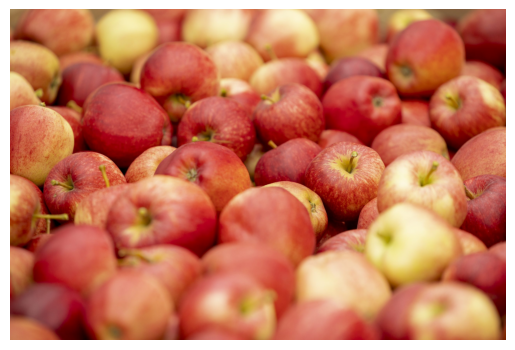

Predicted Label: tomatoes


In [35]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import glob
import os

# Assuming convert_channels function is already defined above

def ImagePrediction(filepath, model, device):
    img = Image.open(filepath).convert("RGB")
    plt.imshow(img)
    plt.axis("off")
    plt.show()

    data_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.Lambda(convert_channels),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5341, 0.5063, 0.4630],
                             std=[0.2098, 0.2081, 0.2181])
    ])

    img_tensor = data_transforms(img).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        output = model(img_tensor)
        _, pred = torch.max(output, 1)

    labels = ['apples', 'tomatoes']
    predicted_label = labels[pred.item()]
    print(f"Predicted Label: {predicted_label}")

# Example: Predict using a test image
test_image_path = glob.glob(os.path.join(test_folder, '**/*.jpeg'), recursive=True)[0]
ImagePrediction('/content/FSP_Apple_Harvest_095-scaled.jpg', model, device)  # Note: 'test_image_path' is used here


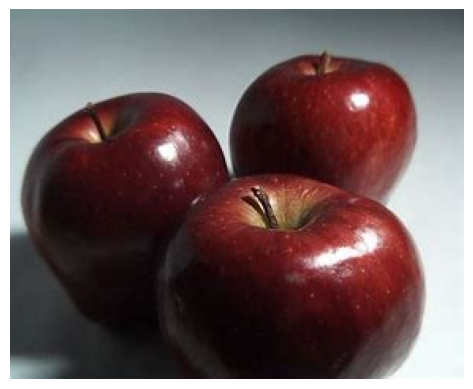

Predicted Label: apples


In [36]:
 ImagePrediction('/content/OIP (5).jpg', model, device)


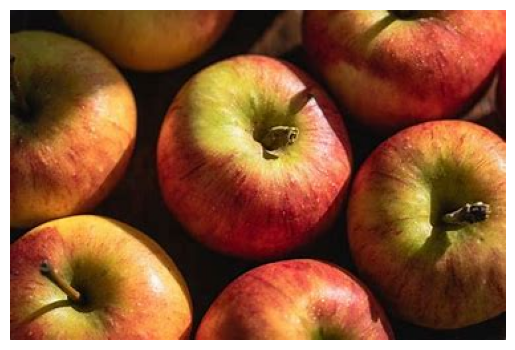

Predicted Label: tomatoes


In [37]:
 ImagePrediction('/content/OIP (4).jpg', model, device)

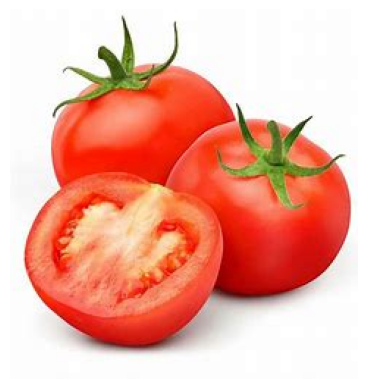

Predicted Label: tomatoes


In [38]:
 ImagePrediction('/content/OIP (6).jpg', model, device)

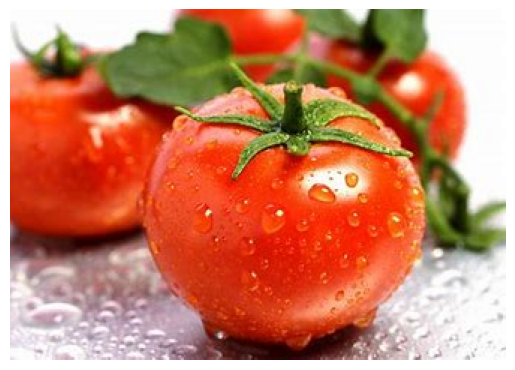

Predicted Label: tomatoes


In [39]:
 ImagePrediction('/content/download (1).jpg', model, device)